In [32]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from functools import partial

os.environ["JAX_PLATFORMS"] = "cpu"
import jax

from bpd import DATA_DIR
from bpd.io import load_dataset

from jax import vmap, jit, grad, Array, random



import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy.stats import norm

from bpd.sample import sample_ellip_prior
from bpd.shear import (
    inv_shear_func1,
    inv_shear_func2,
    inv_shear_transformation,
    shear_transformation,
)


In [39]:
def sample_noisy_eta(rng_key, *, g, sigma_e: float, sigma_m: float, n: int = 1):
    k1, k2 = random.split(rng_key)
    es = sample_ellip_prior(k1, sigma_e, n)
    essh = shear_transformation(es, g)
    etas = vmap(g2eta)(essh)
    noisy_etas = etas.reshape(n, 2) + random.normal(k2, shape=(n, 2)) * sigma_m
    return noisy_etas, etas


def eta2g(eta: Array):
    assert eta.shape == (2,)
    eta1 = eta[0]
    eta2 = eta[1]
    abseta = jnp.sqrt(eta1**2 + eta2**2)
    g1 = eta1 * jnp.tanh(0.5 * abseta) / abseta
    g2 = eta2 * jnp.tanh(0.5 * abseta) / abseta
    return jnp.array([g1, g2])

def g2eta(g: Array):
    assert g.shape == (2,)
    g1 = g[0]
    g2 = g[1]
    absg = jnp.sqrt(g1**2 + g2**2)
    eta1 = g1 * jnp.arctanh(absg) * 2 / absg
    eta2 = g2 * jnp.arctanh(absg) * 2 / absg
    return jnp.array([eta1, eta2])

In [40]:
dirpath = DATA_DIR / "cache_chains" / "exp70_51"
samples_plus_fpath = dirpath / "interim_samples_511_plus.npz"

In [41]:
ds = load_dataset(samples_plus_fpath)
ds.keys()

dict_keys(['samples', 'truth', 'hyper'])

In [42]:
e1_samples = ds['samples']['e1']
e1_samples.shape

(320000, 300)

In [52]:
eta_samples, _  = sample_noisy_eta(random.key(42), g=jnp.array([0.02, 0.0]), sigma_e=0.2, sigma_m=0.2, n=320_000*300)
e1_samples_eta = vmap(eta2g)(eta_samples)[:, 0]

In [53]:
e1_samples_eta.shape

(96000000,)

(array([6.000000e+00, 4.300000e+01, 1.740000e+02, 4.750000e+02,
        1.517000e+03, 4.105000e+03, 9.531000e+03, 2.151700e+04,
        4.503400e+04, 8.594100e+04, 1.541580e+05, 2.622150e+05,
        4.254260e+05, 6.571100e+05, 9.714130e+05, 1.377718e+06,
        1.876691e+06, 2.467130e+06, 3.128136e+06, 3.829070e+06,
        4.553142e+06, 5.230081e+06, 5.833672e+06, 6.313395e+06,
        6.628596e+06, 6.758926e+06, 6.689655e+06, 6.428311e+06,
        5.997920e+06, 5.418472e+06, 4.751884e+06, 4.024881e+06,
        3.297089e+06, 2.605519e+06, 1.987223e+06, 1.455652e+06,
        1.018318e+06, 6.853510e+05, 4.375940e+05, 2.645530e+05,
        1.502270e+05, 8.108200e+04, 4.023600e+04, 1.858900e+04,
        7.880000e+03, 2.940000e+03, 9.900000e+02, 3.280000e+02,
        6.300000e+01, 1.700000e+01, 4.000000e+00]),
 array([-0.92817843, -0.89113255, -0.85408666, -0.81704078, -0.77999489,
        -0.74294901, -0.70590312, -0.66885724, -0.63181135, -0.59476546,
        -0.55771958, -0.52067369, 

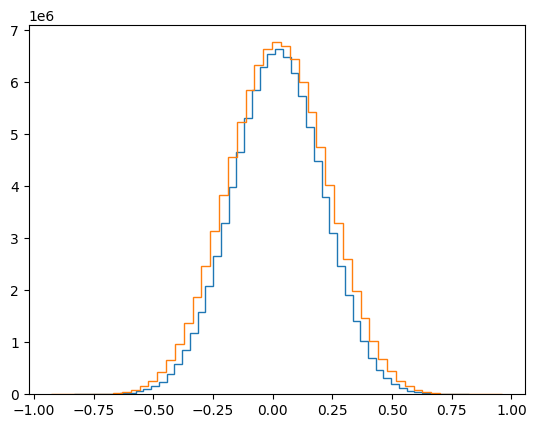

In [54]:
plt.hist(e1_samples.ravel(), bins=51, histtype='step')
plt.hist(e1_samples_eta, bins=51, histtype='step')